# Generate drift trajectories according to Intoy & Rucci, 2020. 

Brownian motion simulation code downloaded from: https://people.sc.fsu.edu/~jburkardt/py_src/brownian_motion_simulation/brownian_motion_simulation.html

Assuming stationary brownian motion with different diffusion constatnt for the different conditions (Snellen vs. fixation or free veiwing) [1].

In order to translate the units used in Intoy & Rucci [1] to pixels assumes the dimension of a single pixel is equivalent to 1 arcmin on the retina ("...roughly matches the filtering of the optics and the spacing of receptors within the foveola.")

[1] Intoy, J., & Rucci, M. (2020). Finely tuned eye movements enhance visual acuity. Nature Communications, 11(1), 795. https://doi.org/10.1038/s41467-020-14616-2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def brownian_motion_simulation ( m = 2, n = 1001, d = 10.0, t = 1.0 ):

#*****************************************************************************80
#
## BROWNIAN_MOTION_SIMULATION simulates Brownian motion.
#
#  Discussion:
#
#    Thanks to Feifei Xu for pointing out a missing factor of 2 in the
#    stepsize calculation, 08 March 2016.
#
#    Thanks to Joerg Peter Pfannmoeller for pointing out a missing factor
#    of M in the stepsize calculation, 23 April 2018.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    10 June 2018
#
#  Author:
#
#    John Burkardt
#
#  Parameters:
#
#    Input, integer M, the spatial dimension.
#    This defaults to 2.
#
#    Input, integer N, the number of time steps to take, plus 1. 
#    This defaults to 1001.
#
#    Input, real D, the diffusion coefficient.  
#    This defaults to 10.0.
#
#    Input, real T, the total time.
#    This defaults to 1.0
#
#    Output, real X(M,N), the initial position at time 0.0, and 
#    the N-1 successive locations of the particle.
#

    #
    #  Set the time step.
    #
    dt = t / float ( n - 1 )

    
    x = np.zeros ( [ m, n ] )
    dx = np.zeros ( [ m, n ] )
    
    step_size = np.sqrt ( 2.0 * m * d * dt ) * np.random.randn ( n )
    dx = np.random.randn ( m, n )

    #
    #  Compute the individual steps.
    #
    for j in range ( 1, n ):
        #
        #  S is the stepsize
        #
#         s = np.sqrt ( 2.0 * m * d * dt ) * np.random.randn ( n )
       
        #
        #  Direction is random.
        #
        if ( m == 1 ):
            dx[j] = step_size[j] * np.ones ( 1 );
        else:
#             dx[0:m,j] = np.random.randn ( m )
            norm_dx = np.sqrt ( np.sum ( dx[:,j] ** 2 ) )
            for i in range ( 0, m ):
                dx[i,j] = step_size[j] * dx[i,j] / norm_dx

        #
        #  Each position is the sum of the previous steps.
        #
        x[0:m,j] = x[0:m,j-1] + dx[0:m,j]

    return x
   

def diffusion_const_conversion(D_angle):
#     input - D_angle: diffusion factor in units of arcmin^2*sec^(-1)
#     output- D_receptors: diffusion factor in units of pix^2*sec^(-1)
   
    k = 1 # conversion factor, photoreceptor/pixel diameter in arcmin [pix*arcmin^(-1)]
          # k=1 means that one photoreceptor in the fovea spans 1 arcmin [1].
    
    D_receptors = k**2*D_angle
    
    return D_receptors

def gen_drift_traj( D_arcmin = 10.998, duration = 0.3, N = 5 ):
#     D_arcmin - Diffusion constant with units of arcmin^2*sec^(-1).
    
    D = diffusion_const_conversion(D_arcmin) #D- Diffusion constant with units of receptor_spacing^2*sec^(-1)
    m = 2
    n = int(duration*1000+1) #assuming original traj is sampled at 1KHz
    traj = brownian_motion_simulation(m=m, n=n, d=D, t=duration)
    
    #subsampling traj to produce trajectory with N points evenly distributed in time
    subsamp_traj = traj[:,range(0,n,n//(N-1))]
    
    return traj, subsamp_traj


def gen_drift_traj_condition(duration = 0.3, N = 5, snellen = True):
# duration- duration of the drift in seconds
# N- the number of points the subsmapled trajectory should include
# snellen- True: generate Snellen-condition drift, False: generate Fixation condition drift
    
    D_IR = 0.0
    if snellen:
        D_IR = 10.998 # see [1] source data file 
    else:
        D_IR = 30.155 # see [1] source data file
        
    traj, traj_sb = gen_drift_traj(D_arcmin = D_IR, duration=duration, N=N)
    return traj, traj_sb
        

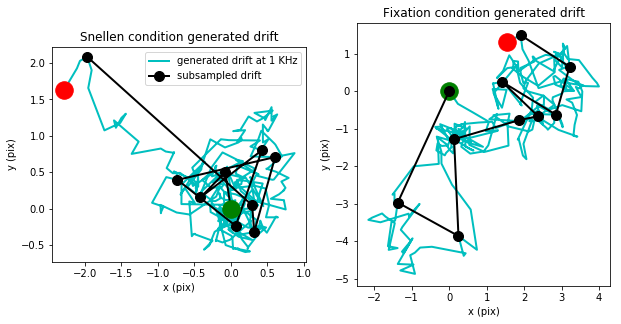

In [13]:
traj_sn, traj_sb_sn = gen_drift_traj_condition(duration=0.3, N=10, snellen = True)
traj_fix, traj_sb_fix = gen_drift_traj_condition(duration=0.3, N=10, snellen = False)

fig,[ax1, ax2] = plt.subplots(1,2, figsize=(10,10))

ax1.plot( traj_sn[0,:], traj_sn[1,:], 'c', LineWidth = 2 )
ax1.plot( traj_sb_sn[0,:], traj_sb_sn[1,:], 'k-o', LineWidth = 2, markersize=10 )
ax1.plot( traj_sn[0,0], traj_sn[1,0], 'g.', markersize = 35 )
ax1.plot( traj_sn[0,-1], traj_sn[1,-1], 'r.', markersize = 35 )
ax1.set_xlabel('x (pix)')
ax1.set_ylabel('y (pix)')
ax1.set_title('Snellen condition generated drift')
ax1.legend(['generated drift at 1 KHz', 'subsampled drift'])
ax1.set_aspect('equal', 'box')

ax2.plot( traj_fix[0,:], traj_fix[1,:], 'c', LineWidth = 2 )
ax2.plot( traj_fix[0,0], traj_fix[1,0], 'g.', markersize = 35 )
ax2.plot( traj_fix[0,-1], traj_fix[1,-1], 'r.', markersize = 35 )
ax2.plot( traj_sb_fix[0,:], traj_sb_fix[1,:], 'k-o', LineWidth = 2, markersize=10 )
ax2.set_xlabel('x (pix)')
ax2.set_ylabel('y (pix)')
ax2.set_title('Fixation condition generated drift')
ax2.set_aspect('equal', 'box')

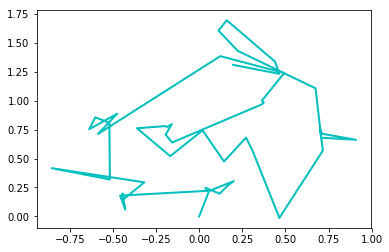

In [17]:
# traj_sn, traj_sb_sn = gen_drift_traj_condition(duration=0.3, N=10, snellen = True)
traj_fix, traj_sb_fix = gen_drift_traj_condition(duration=0.05, N=10, snellen = False)

plt.plot( traj_fix[0,:], traj_fix[1,:], 'c', LineWidth = 2 )


<Figure size 432x288 with 0 Axes>

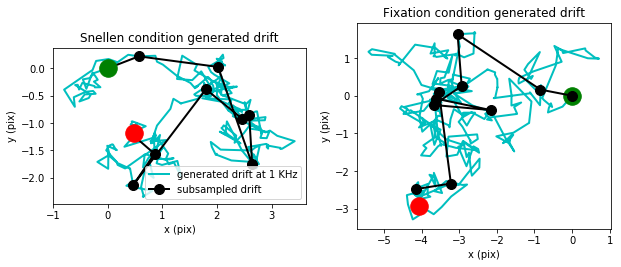

<Figure size 432x288 with 0 Axes>

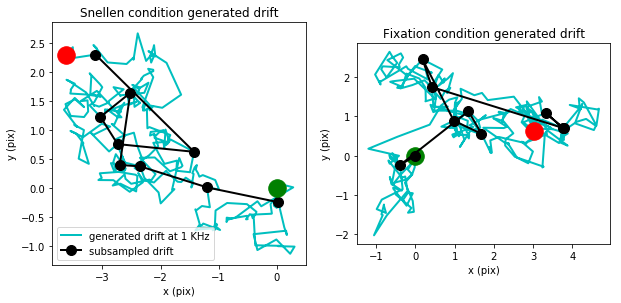

<Figure size 432x288 with 0 Axes>

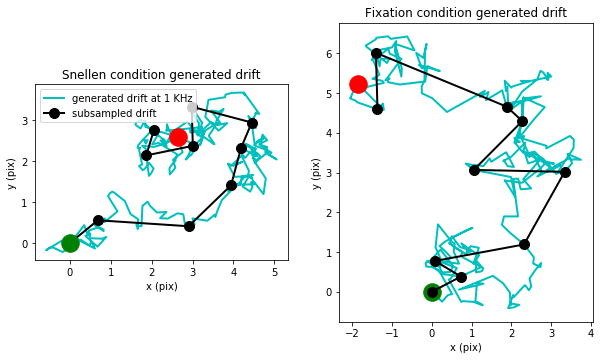

<Figure size 432x288 with 0 Axes>

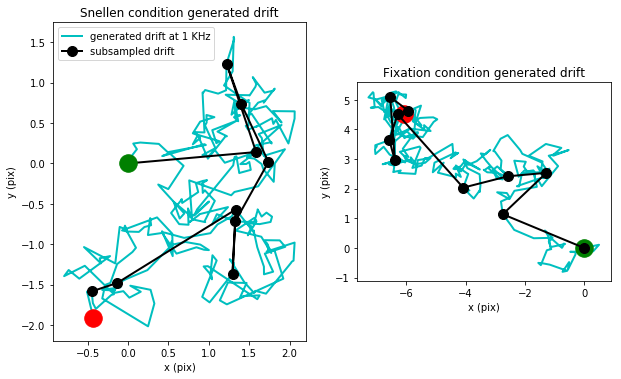

<Figure size 432x288 with 0 Axes>

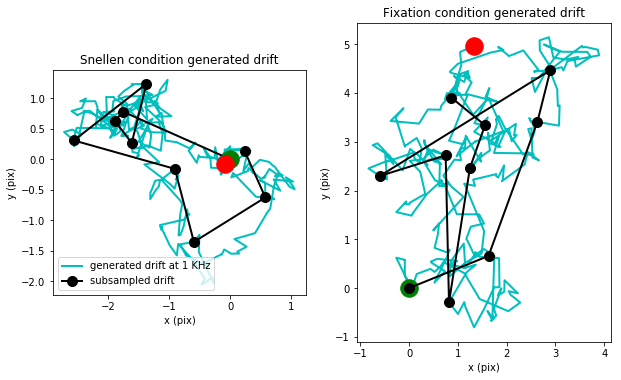

In [7]:
for uu in range(5):
    plt.figure()
    traj_sn, traj_sb_sn = gen_drift_traj_condition(duration=0.3, N=10, snellen = True)
    traj_fix, traj_sb_fix = gen_drift_traj_condition(duration=0.3, N=10, snellen = False)

    fig,[ax1, ax2] = plt.subplots(1,2, figsize=(10,10))

    ax1.plot( traj_sn[0,:], traj_sn[1,:], 'c', LineWidth = 2 )
    ax1.plot( traj_sb_sn[0,:], traj_sb_sn[1,:], 'k-o', LineWidth = 2, markersize=10 )
    ax1.plot( traj_sn[0,0], traj_sn[1,0], 'g.', markersize = 35 )
    ax1.plot( traj_sn[0,-1], traj_sn[1,-1], 'r.', markersize = 35 )
    ax1.set_xlabel('x (pix)')
    ax1.set_ylabel('y (pix)')
    ax1.set_title('Snellen condition generated drift')
    ax1.legend(['generated drift at 1 KHz', 'subsampled drift'])
    ax1.set_aspect('equal', 'box')

    ax2.plot( traj_fix[0,:], traj_fix[1,:], 'c', LineWidth = 2 )
    ax2.plot( traj_fix[0,0], traj_fix[1,0], 'g.', markersize = 35 )
    ax2.plot( traj_fix[0,-1], traj_fix[1,-1], 'r.', markersize = 35 )
    ax2.plot( traj_sb_fix[0,:], traj_sb_fix[1,:], 'k-o', LineWidth = 2, markersize=10 )
    ax2.set_xlabel('x (pix)')
    ax2.set_ylabel('y (pix)')
    ax2.set_title('Fixation condition generated drift')
    ax2.set_aspect('equal', 'box')

In [8]:
traj_sb_sn.shape

(2, 10)

In [11]:
import time

In [12]:
t=time.time()
for uu in range(10000):
    traj_sn, traj_sb_sn = gen_drift_traj_condition(duration=0.3, N=10, snellen = True)
print('time for 10K iterations:',time.time()-t)

time for 10K iterations: 28.83991050720215
